In [1]:
import torch
torch.set_grad_enabled(False)
import sys
import time
import random
import csv
import numpy as np
import threading

import scipy.io
from scipy.io import loadmat

import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

import copy
# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')




Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


### How this works:

We choose initial training points to be considered a random set of images to present to the retina. On this set, the complete GP will be run , to find STA paramaters eps_0: center, beta: width , rho: smoothness

We run the algorithm saving the seed used for picking the training images, so that this set can be changed and different runs with different initial conditions can be averaged.

1. Import the dataset and create a total training set X,R
2. Pick the cell and the initial training points, extracted randomly. These correspond also to the number of inducing points
3. Save the seed so you can keep the initial training set, and the fitted model
3. 


### Parameters of the training

In [2]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

cellid       = 8         # Choose cell
ntrain_start = 50        # Number of first training data points

kernfun      = 'acosker' # Choose kernel function

nEstep       = 10         # Total number of E-steps iterations.
nFparamstep  = 10  
nMstep       = 10         # Total number of M-steps iterations. 
maxiter      = 10         # Iterations of the optimization algorithm comprising M and E steps

ntilde       = ntrain_start

### Import dataset and generate starting dataset

Create starting dataset on which to train with m step with ntilde = ntrain_start

In [3]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)

n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials

# Choose a random subset of the data and save the idx
all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
torch.manual_seed(8)
torch.cuda.manual_seed(8)
all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

test_1000_idx = all_idx_perm[-1000:]                                     # These will be the indices of the test set
all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
rndm_idx      = all_idx_perm[:ntrain_start]                              # These will be the indices of the initial training. This way ensures not repetitions.


start_idx     = rndm_idx
# start_idx     = rndm_idx.sort()[0]
in_use_idx    = start_idx
xtilde_idx    = in_use_idx
remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]
# remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

# Set the starting set
xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
X_in_use      = X[in_use_idx,:]
X_remaining   = X[remaining_idx,:]
X_test_1000   = X[test_1000_idx,:]

R_remaining   = R[remaining_idx]
R_in_use      = R[in_use_idx]
R_test_1000   = R[test_1000_idx]

# Estimate memory usage
# Calculate memory usage for each tensor
X_memory = X.element_size() * X.nelement()
r_memory = R.element_size() * R.nelement()
# Total memory usage in bytes
total_memory_bytes = X_memory + r_memory
# Convert bytes to megabytes (MB)
total_memory_MB = total_memory_bytes / (1024 ** 2)
print(f'Total dataset memory on GPU: {total_memory_MB:.2f} MB')


Total dataset memory on GPU: 281.23 MB


### Select cell, starting hyperparameters and firing rate parameters

In [4]:
torch.set_grad_enabled(False)
# For details on the hyperparameters choice see one_cell_fit.ipynb
logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 
# logbetaexpr = torch.tensor(4.65)
# logrhoexpr = torch.tensor(4.3)
sigma_0    = torch.tensor(1.0)
Amp        = torch.tensor(1.0) 
eps_0x     = torch.tensor(0.0001)
eps_0y     = torch.tensor(0.0001)
# Hypermarameters, if needed to be set manually
theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

# Set the gradient of the hyperparemters to be updatable 
for key, value in theta.items(): # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
    # if key == 'Amp':
        # continue
    theta[key] = value.requires_grad_()

# If hyperparameters are set manually:
# theta = prev_theta
hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

A        = torch.tensor(0.01)
logA     = torch.log(A)
# lambda0  = torch.tensor(0.31)
lambda0  = torch.tensor(1.)
f_params = {'logA': logA, 'lambda0':lambda0}
f_params['logA'] = f_params['logA'].requires_grad_() # The optimal lambda0 is given with a fixed A.

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

init_model = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde_start,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
        # 'm':                 torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
        #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
    }

updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069


### Fit the starting model
And save it needed to start a new active fit

Initial Loss: 128.4550
Loss iter 1: 53.8982
Loss iter 2: 52.4540
Loss iter 3: 52.0129
Loss iter 4: 52.3094
Loss iter 5: 52.1888
Loss iter 6: 52.1174
Loss iter 7: 52.0710
Loss iter 8: 52.0340
Loss iter 9: 51.9940

Time spent for E-steps:       0.600s,
Time spent for f params:      0.399s
Time spent for m update:      0.201s
Time spent for M-steps:       0.590s
Time spent for All-steps:     1.190s
Time spent computing Kernels: 0.018s
Time spent computing Loss:    0.003s

Time total after init:        1.217s
Time total before init:       1.274s
Final Loss: 51.9940


 Pietro's model: R2 = 0.27 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



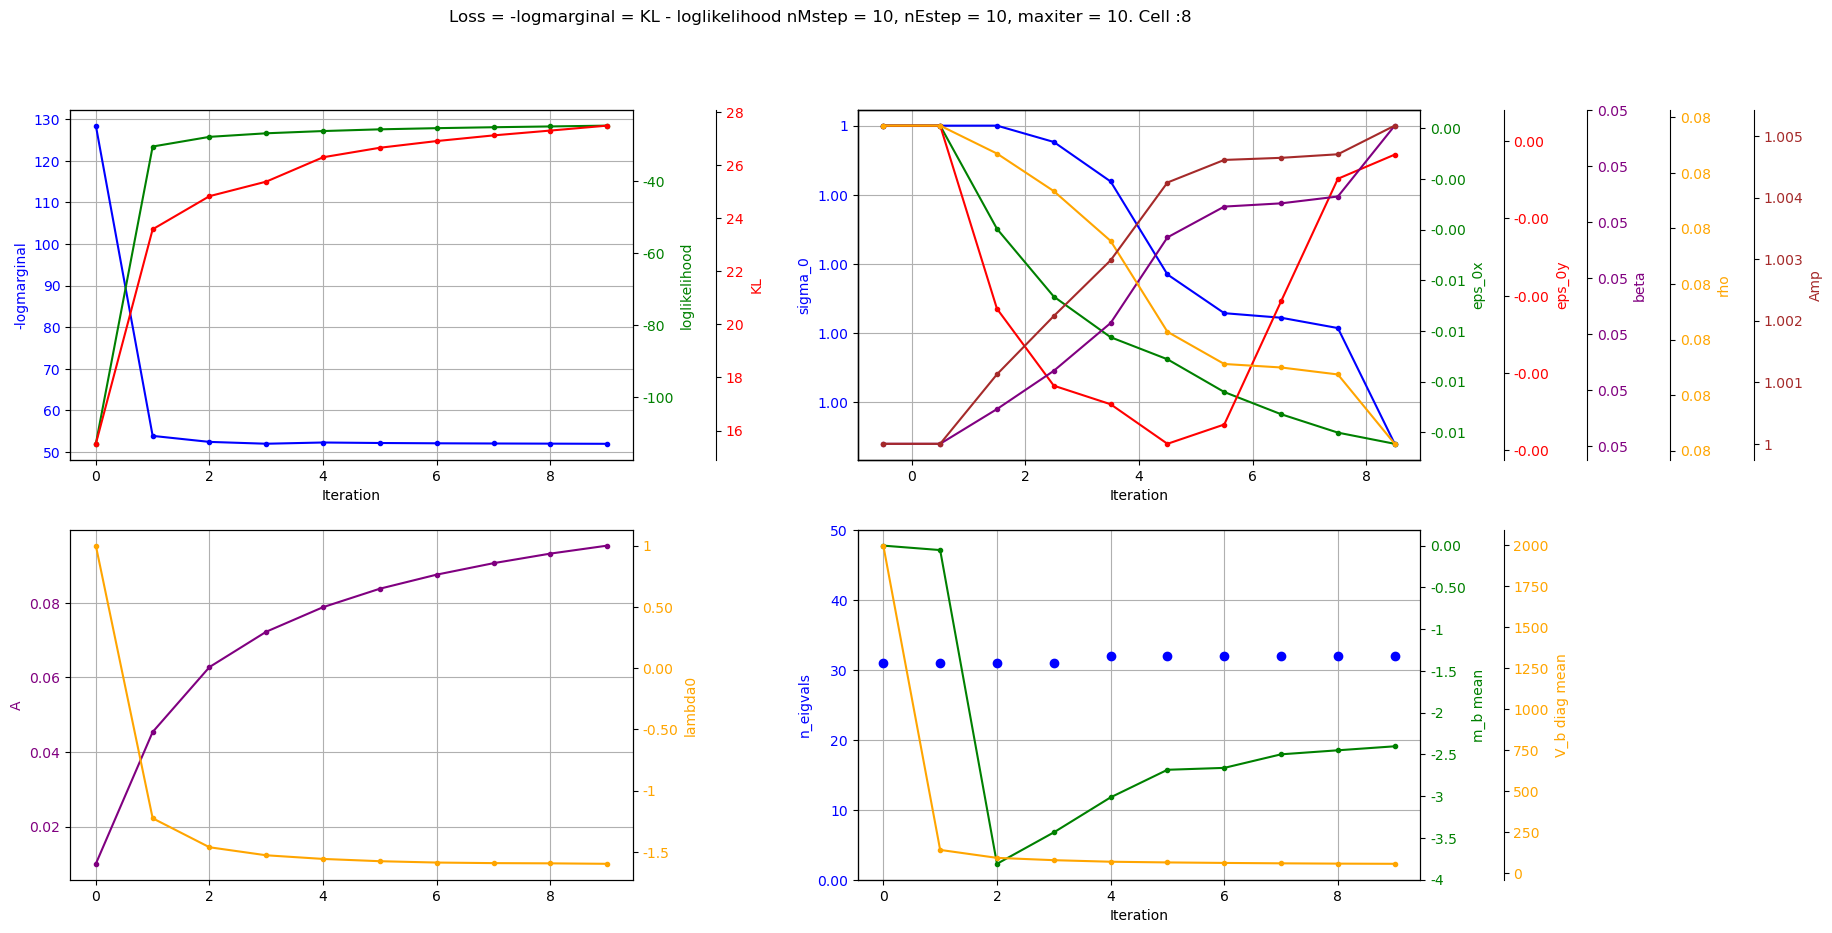

In [5]:
torch.set_grad_enabled(False)
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
start_model = fit_model

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save the model
# utils.save_model(start_model, f'models/starting_models_active_learning/cell:{cellid}_nstart:{ntrain_start}', additional_description='Starting model for active learning')

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )
# spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **start_model )

utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))


### Save or load model

In [6]:
# Save the model
# utils.save_model(fit_model, f'models/bugs/cell:{cellid}', additional_description='Model started with 50 ntilde=ntrain, randomly picked images until nan in r2. Saved last model (after fit ). It gives Nan')
# start_model = utils.load_model(f'models/starting_models_active_learning/cell:8_nstart:20')

### Evaluate the utility of each remaining image
New version

In [7]:
in_use_idx    = start_model['fit_parameters']['in_use_idx']
xtilde_idx    = start_model['fit_parameters']['xtilde_idx']

remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

X_remaining = X[remaining_idx]
R_remaining = R[remaining_idx]

xtilde      = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

xstar = X_remaining

kernfun       = start_model['fit_parameters']['kernfun']
mask          = start_model['mask']
C             = start_model['C']
B             = start_model['B']
K_tilde_b     = start_model['K_tilde_b']
K_tilde_inv_b = start_model['K_tilde_inv_b']
K_b           = start_model['K_b']
Kvec          = start_model['Kvec']
m_b           = start_model['m_b']
V_b           = start_model['V_b']    
f_params_fit  = start_model['f_params']
A             = torch.exp(f_params_fit['logA'])
lambda0       = torch.exp(f_params_fit['loglambda0']) if 'loglambda0' in f_params_fit else f_params_fit['lambda0']

start_time = time.time()

# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  

logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t

# Estimate the utility and cap the maximum r ( used in a summation to infinity )
r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
u2d = utils.nd_utility(logf_var, logf_mean, r_masked )
print(f'\nElapsed time for lambda moments and utility : {time.time()-start_time:.2f} seconds')  



Elapsed time for lambda moments and utility : 0.02 seconds


### Find the index(es) for the most useful image 
Check the correspondence between the index: ```i_best``` of the ```xstar = X_remaining``` images with the one: ```x_idx_best```  for the complete dataset ```X```

In [8]:
i_best     = u2d.argmax()           # Index of the best image in the utility vector
x_idx_best = remaining_idx[i_best]  # Index of the best image in the dataset indices
print(f'Utility: {u2d[i_best].item():<8.4f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')


# Using the indexes of the utility
Kvec = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, xstar[:,mask], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 

lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var[i_best], logf_mean[i_best], r_masked)} and f_mean :{torch.exp(logf_mean[i_best]).item():8.4f}')


# Using the indixes of the dataset X
# Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
Kvec = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=None, C=C, dC=None, diag=True)
K    = utils.acosker(theta, X[x_idx_best,mask][None,:], x2=xtilde_start[:,mask], C=C, dC=None, diag=False)
K_b  = K @ B 
lambda_m_t, lambda_var_t = utils.lambda_moments( X[x_idx_best,mask][None,:], K_tilde_b, K_b@K_tilde_inv_b, Kvec, K_b, C, m_b, V_b, theta, kernfun)  
logf_mean = A*lambda_m_t + lambda0
logf_var  = A**2 * lambda_var_t
print(f' this has utility {utils.nd_utility(logf_var, logf_mean, r_masked)} and f_mean :{torch.exp(logf_mean).item():8.4f}')

Utility: 0.0746   |  Best image ID: 1875  | Best image index: 3072
 this has utility tensor([0.0746], device='cuda:0') and f_mean :  0.9790
 this has utility tensor([0.0746], device='cuda:0') and f_mean :  0.9790


### Active learning loop
Update the indexes tensors and fit the new model in a loop 

After fitting the model with the dataset incremented by one image, reevaluate the utility, find the best mage index and loop.


Using device: cuda:0 (from utils.py)
=========== New image number 0 ====================
Utility: 72.124342 |  Best image ID: 1872  | Best image index: 905

Number of inducing points: 51
Initial Loss: 72.4317
Loss iter 1: 56.8023
Loss iter 2: 56.5573
Loss iter 3: 56.3135
Loss iter 4: 55.5814
Loss iter 5: 55.3550
Loss iter 6: 55.1563
Loss iter 7: 54.9704
Loss iter 8: 55.3001
Loss iter 9: 55.1481

Time spent for E-steps:       0.303s,
Time spent for f params:      0.251s
Time spent for m update:      0.052s
Time spent for M-steps:       0.647s
Time spent for All-steps:     0.950s
Time spent computing Kernels: 0.018s
Time spent computing Loss:    0.004s

Time total after init:        0.975s
Time total before init:       0.977s
Final Loss: 55.1481


 Pietro's model: R2 = 0.24 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



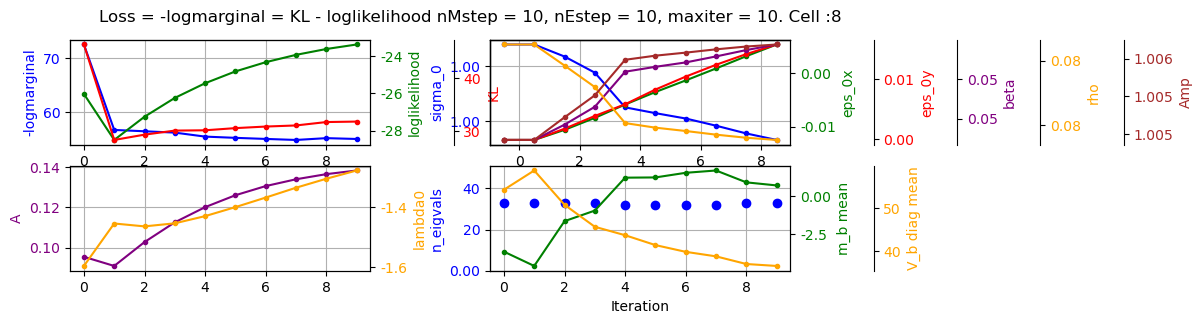

=========== New image number 1 ====================
Utility: 46.759880 |  Best image ID: 1972  | Best image index: 2453

Number of inducing points: 52
Initial Loss: 59.0816
Loss iter 1: 56.4933
Loss iter 2: 56.4273
Loss iter 3: 56.3065
Loss iter 4: 56.2080
Loss iter 5: 56.0909
Loss iter 6: 55.9761
Loss iter 7: 55.8613
Loss iter 8: 55.6580
Loss iter 9: 55.4502

Time spent for E-steps:       0.492s,
Time spent for f params:      0.440s
Time spent for m update:      0.052s
Time spent for M-steps:       0.730s
Time spent for All-steps:     1.222s
Time spent computing Kernels: 0.019s
Time spent computing Loss:    0.005s

Time total after init:        1.248s
Time total before init:       1.250s
Final Loss: 55.4502


 Pietro's model: R2 = 0.54 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



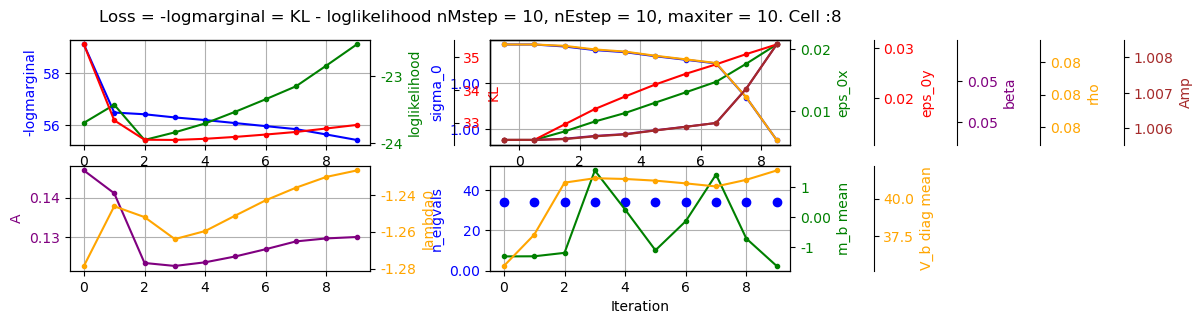

=========== New image number 2 ====================
Utility: 13.972927 |  Best image ID: 246  | Best image index: 2269

Number of inducing points: 53
Initial Loss: 76.4924
Loss iter 1: 50.6588
Loss iter 2: 48.8726
Loss iter 3: 48.2285
Loss iter 4: 48.0091
Loss iter 5: 47.8963
Loss iter 6: 47.8241
Loss iter 7: 47.7667
Loss iter 8: 47.8023
Loss iter 9: 47.8292

Time spent for E-steps:       0.404s,
Time spent for f params:      0.351s
Time spent for m update:      0.054s
Time spent for M-steps:       0.689s
Time spent for All-steps:     1.093s
Time spent computing Kernels: 0.020s
Time spent computing Loss:    0.006s

Time total after init:        1.122s
Time total before init:       1.123s
Final Loss: 47.8292


 Pietro's model: R2 = 0.56 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



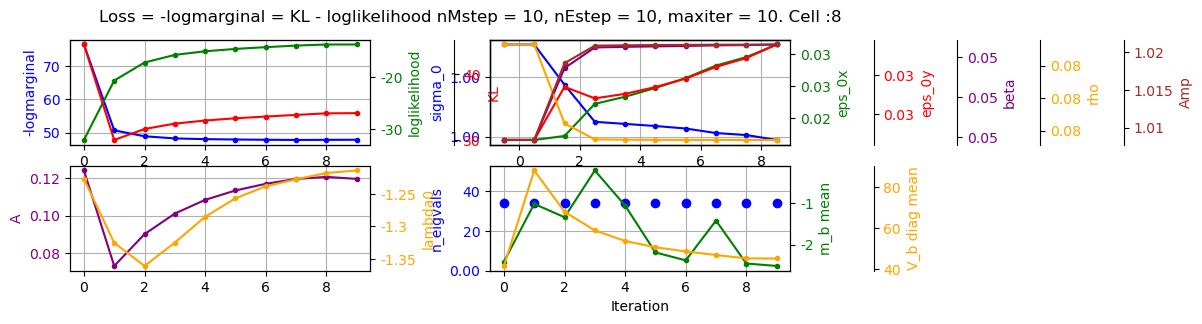

=========== New image number 3 ====================
Utility: 11.004694 |  Best image ID: 784  | Best image index: 1506

Number of inducing points: 54
Initial Loss: 57.0671
Loss iter 1: 50.1588
Loss iter 2: 49.0159
Loss iter 3: 48.8427
Loss iter 4: 48.4687
Loss iter 5: 48.2931
Loss iter 6: 48.1409
Loss iter 7: 47.9874
Loss iter 8: 47.8314
Loss iter 9: 48.1797

Time spent for E-steps:       0.399s,
Time spent for f params:      0.347s
Time spent for m update:      0.052s
Time spent for M-steps:       0.746s
Time spent for All-steps:     1.144s
Time spent computing Kernels: 0.021s
Time spent computing Loss:    0.005s

Time total after init:        1.172s
Time total before init:       1.174s
Final Loss: 48.1797


 Pietro's model: R2 = 0.60 ± 0.02 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



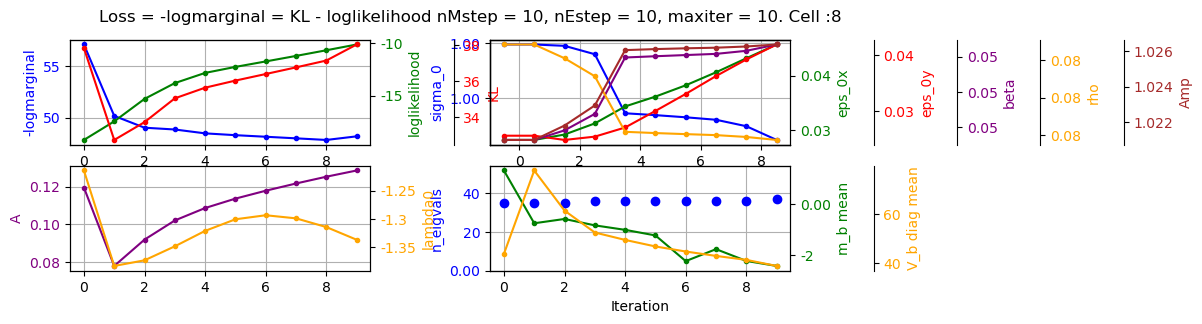

=========== New image number 4 ====================
Utility: 11.240590 |  Best image ID: 451  | Best image index: 2496

Number of inducing points: 55
Initial Loss: 51.0974
Loss iter 1: 48.5675
Loss iter 2: 48.4743
Loss iter 3: 48.3892
Loss iter 4: 48.3278
Loss iter 5: 48.2658
Loss iter 6: 48.1888
Loss iter 7: 48.1094
Loss iter 8: 48.0397
Loss iter 9: 47.9840

Time spent for E-steps:       0.296s,
Time spent for f params:      0.243s
Time spent for m update:      0.053s
Time spent for M-steps:       0.780s
Time spent for All-steps:     1.077s
Time spent computing Kernels: 0.020s
Time spent computing Loss:    0.005s

Time total after init:        1.103s
Time total before init:       1.105s
Final Loss: 47.9840


 Pietro's model: R2 = 0.55 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



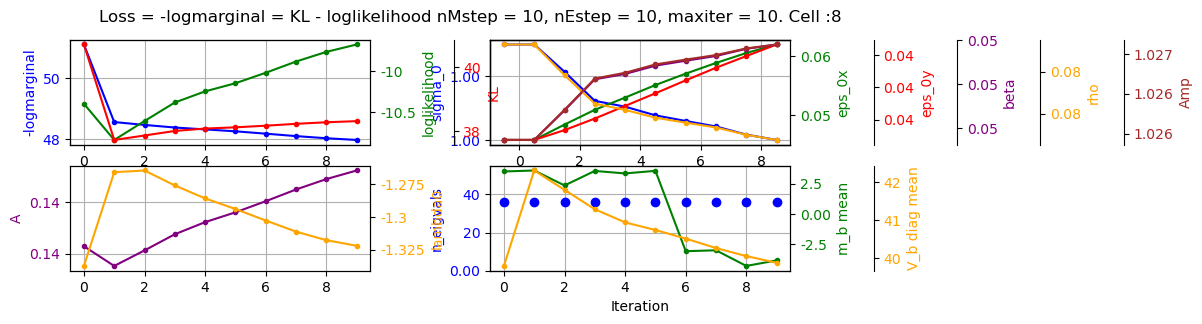

=========== New image number 5 ====================
Utility: 92.520119 |  Best image ID: 1129  | Best image index: 2395

Number of inducing points: 56
Initial Loss: 54.7663
Loss iter 1: 50.7248
Loss iter 2: 50.4200
Loss iter 3: 50.3014
Loss iter 4: 50.2465
Loss iter 5: 50.2199
Loss iter 6: 50.2046
Loss iter 7: 50.1955
Loss iter 8: 50.1897
Loss iter 9: 50.1859

Time spent for E-steps:       0.323s,
Time spent for f params:      0.270s
Time spent for m update:      0.053s
Time spent for M-steps:       1.018s
Time spent for All-steps:     1.341s
Time spent computing Kernels: 0.022s
Time spent computing Loss:    0.005s

Time total after init:        1.370s
Time total before init:       1.372s
Final Loss: 50.1859


 Pietro's model: R2 = 0.56 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



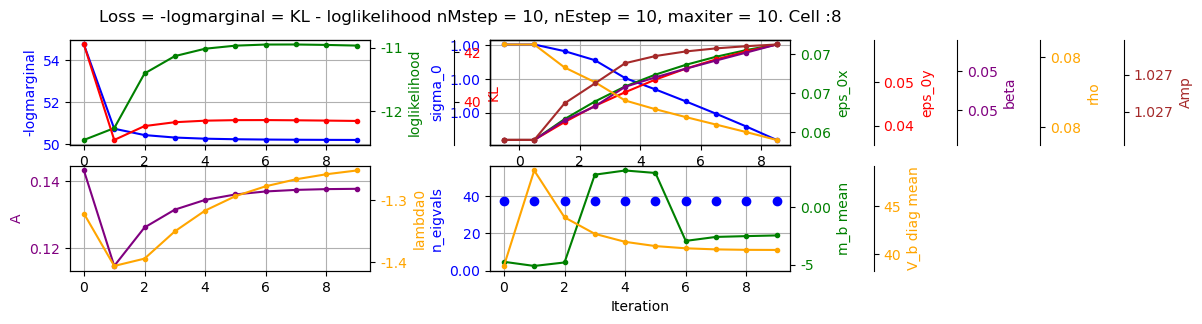

=========== New image number 6 ====================
Utility: 45.188644 |  Best image ID: 1851  | Best image index: 2524

Number of inducing points: 57
Initial Loss: 58.6572
Loss iter 1: 52.6202
Loss iter 2: 51.9681
Loss iter 3: 51.7635
Loss iter 4: 51.6928
Loss iter 5: 51.6617
Loss iter 6: 51.6521
Loss iter 7: 52.0660
Loss iter 8: 52.0460
Loss iter 9: 52.0315

Time spent for E-steps:       0.364s,
Time spent for f params:      0.313s
Time spent for m update:      0.051s
Time spent for M-steps:       1.100s
Time spent for All-steps:     1.464s
Time spent computing Kernels: 0.020s
Time spent computing Loss:    0.004s

Time total after init:        1.491s
Time total before init:       1.493s
Final Loss: 52.0315


 Pietro's model: R2 = 0.57 ± 0.02 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



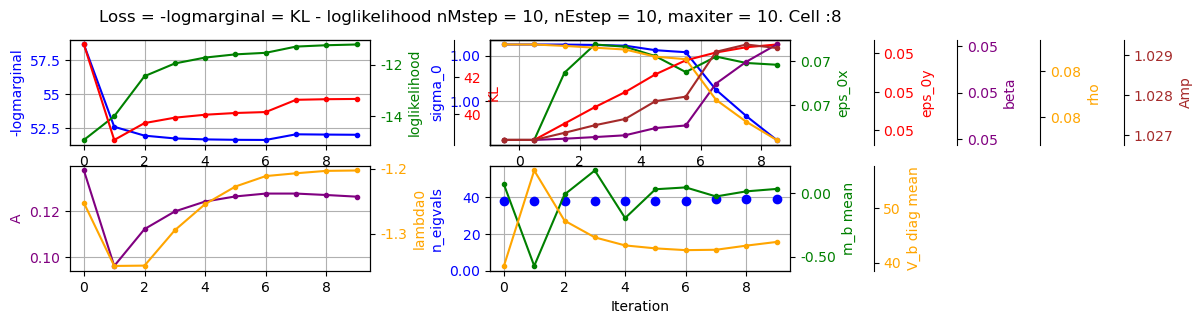

=========== New image number 7 ====================
Utility: 43.478718 |  Best image ID: 499  | Best image index: 969

Number of inducing points: 58
Initial Loss: 64.4269
Loss iter 1: 56.1824
Loss iter 2: 55.9637
Loss iter 3: 55.8417
Loss iter 4: 55.7840
Loss iter 5: 55.8113
Loss iter 6: 55.8993
Loss iter 7: 55.8937
Loss iter 8: 55.8770
Loss iter 9: 55.8603

Time spent for E-steps:       0.330s,
Time spent for f params:      0.278s
Time spent for m update:      0.052s
Time spent for M-steps:       0.686s
Time spent for All-steps:     1.016s
Time spent computing Kernels: 0.021s
Time spent computing Loss:    0.005s

Time total after init:        1.044s
Time total before init:       1.046s
Final Loss: 55.8603


 Pietro's model: R2 = 0.55 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



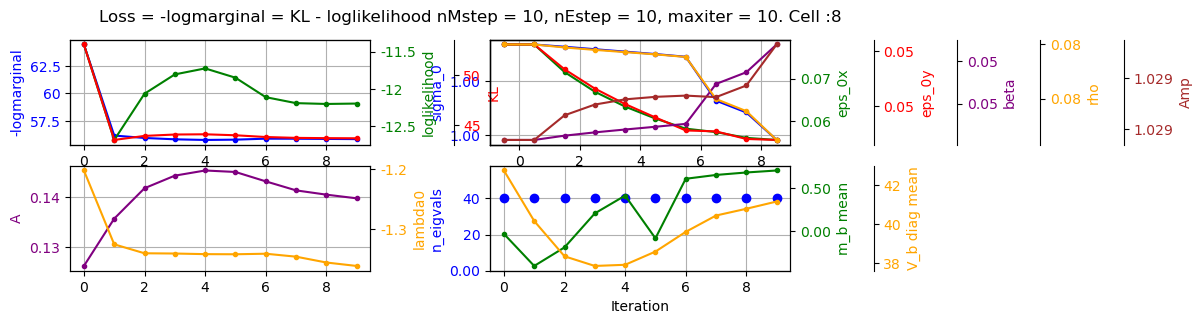

=========== New image number 8 ====================
Utility: 12.843293 |  Best image ID: 2082  | Best image index: 1136

Number of inducing points: 59
Initial Loss: 65.2767
Loss iter 1: 58.6223
Loss iter 2: 57.0263
Loss iter 3: 56.2808
Loss iter 4: 56.4792
Loss iter 5: 56.3807
Loss iter 6: 56.3385
Loss iter 7: 56.3128
Loss iter 8: 56.2954
Loss iter 9: 56.2869

Time spent for E-steps:       0.407s,
Time spent for f params:      0.354s
Time spent for m update:      0.053s
Time spent for M-steps:       0.832s
Time spent for All-steps:     1.240s
Time spent computing Kernels: 0.024s
Time spent computing Loss:    0.005s

Time total after init:        1.271s
Time total before init:       1.273s
Final Loss: 56.2869


 Pietro's model: R2 = 0.55 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



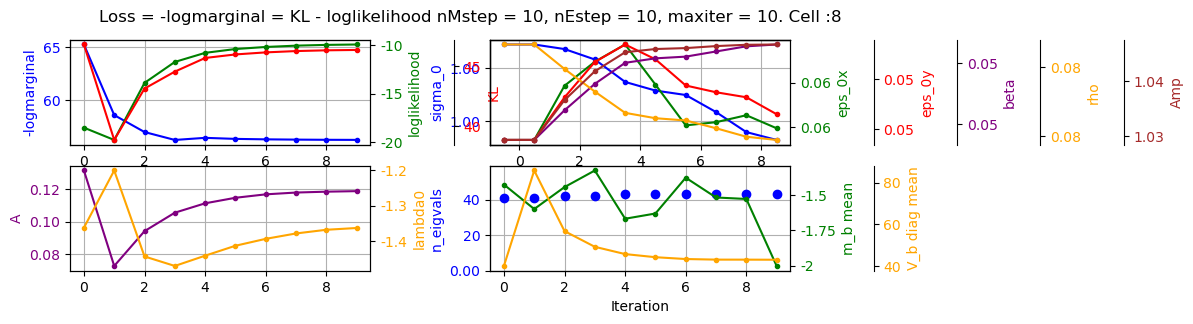

=========== New image number 9 ====================
Utility: 15.602064 |  Best image ID: 737  | Best image index: 2916

Number of inducing points: 60
Initial Loss: 64.7135
Loss iter 1: 59.0633
Loss iter 2: 59.4753
Loss iter 3: 59.4165
Loss iter 4: 59.3934
Loss iter 5: 59.3857
Loss iter 6: 59.3799
Loss iter 7: 59.3771
Loss iter 8: 59.3747
Loss iter 9: 59.3731

Time spent for E-steps:       0.295s,
Time spent for f params:      0.242s
Time spent for m update:      0.053s
Time spent for M-steps:       0.898s
Time spent for All-steps:     1.194s
Time spent computing Kernels: 0.024s
Time spent computing Loss:    0.005s

Time total after init:        1.224s
Time total before init:       1.226s
Final Loss: 59.3731


 Pietro's model: R2 = 0.53 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



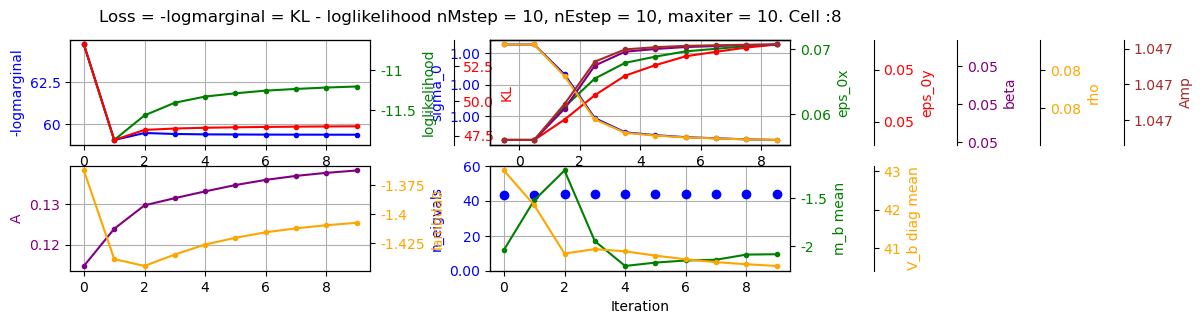

=========== New image number 10 ====================
Utility: 16.586697 |  Best image ID: 2044  | Best image index: 2874

Number of inducing points: 61
Initial Loss: 62.8348
Loss iter 1: 60.1299
Loss iter 2: 60.9003
Loss iter 3: 60.8091
Loss iter 4: 61.1864
Loss iter 5: 61.1292
Loss iter 6: 61.1140
Loss iter 7: 61.1016
Loss iter 8: 61.0945
Loss iter 9: 61.5694

Time spent for E-steps:       0.304s,
Time spent for f params:      0.250s
Time spent for m update:      0.055s
Time spent for M-steps:       0.837s
Time spent for All-steps:     1.141s
Time spent computing Kernels: 0.025s
Time spent computing Loss:    0.005s

Time total after init:        1.174s
Time total before init:       1.176s
Final Loss: 61.5694


 Pietro's model: R2 = 0.56 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



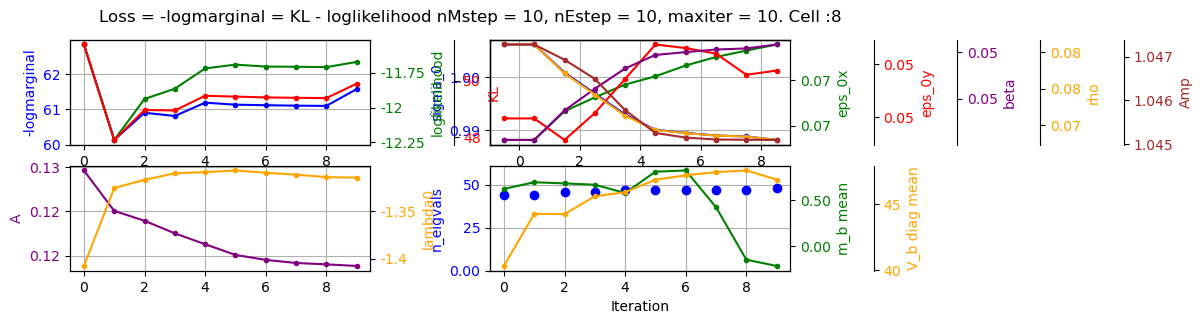

=========== New image number 11 ====================
Utility: 3.568902 |  Best image ID: 490  | Best image index: 842

Number of inducing points: 62
Initial Loss: 69.7167
Loss iter 1: 63.8007
Loss iter 2: 63.3436
Loss iter 3: 62.9849
Loss iter 4: 62.8257
Loss iter 5: 62.7680
Loss iter 6: 62.7432
Loss iter 7: 63.1609
Loss iter 8: 63.0793
Loss iter 9: 63.4967

Time spent for E-steps:       0.387s,
Time spent for f params:      0.332s
Time spent for m update:      0.055s
Time spent for M-steps:       0.855s
Time spent for All-steps:     1.242s
Time spent computing Kernels: 0.024s
Time spent computing Loss:    0.005s

Time total after init:        1.273s
Time total before init:       1.275s
Final Loss: 63.4967


 Pietro's model: R2 = 0.53 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



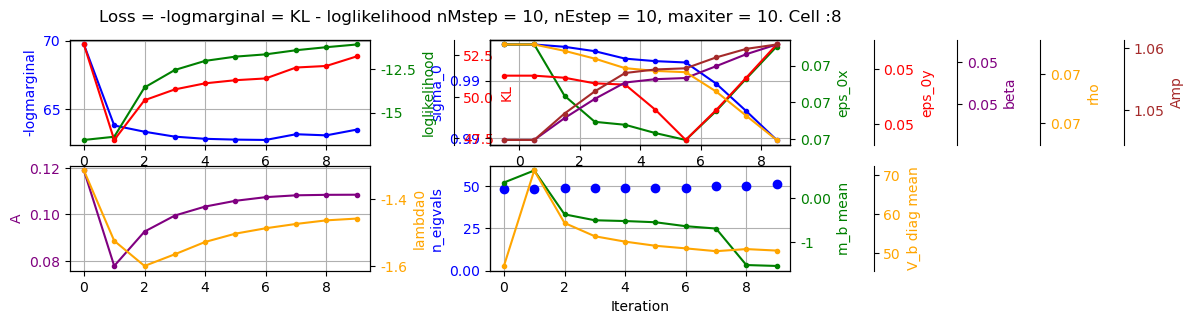

=========== New image number 12 ====================
Utility: 3.361702 |  Best image ID: 1620  | Best image index: 1245

Number of inducing points: 63
Initial Loss: 69.2114
Loss iter 1: 65.6375
Loss iter 2: 65.6113
Loss iter 3: 65.5984
Loss iter 4: 65.5377
Loss iter 5: 65.5297
Loss iter 6: 65.4662
Loss iter 7: 65.4570
Loss iter 8: 65.3992
Loss iter 9: 65.3898

Time spent for E-steps:       0.317s,
Time spent for f params:      0.262s
Time spent for m update:      0.055s
Time spent for M-steps:       0.850s
Time spent for All-steps:     1.168s
Time spent computing Kernels: 0.024s
Time spent computing Loss:    0.005s

Time total after init:        1.199s
Time total before init:       1.201s
Final Loss: 65.3898


 Pietro's model: R2 = 0.52 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



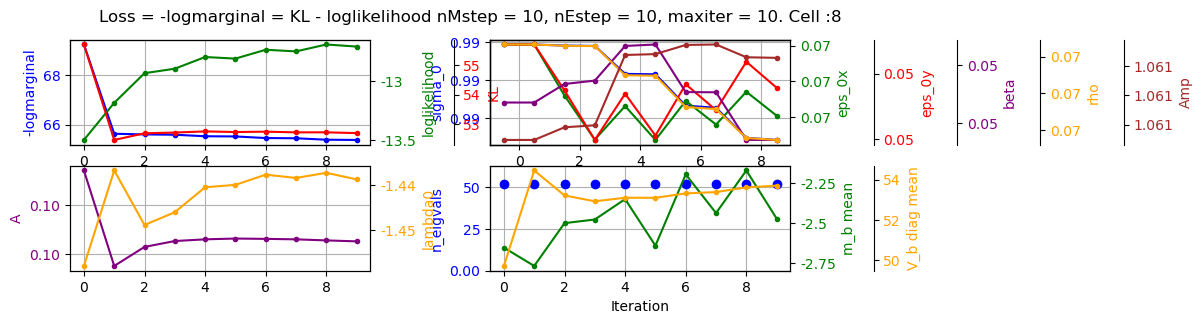

=========== New image number 13 ====================
Utility: 1.437608 |  Best image ID: 1125  | Best image index: 2614

Number of inducing points: 64
Initial Loss: 71.0928
Loss iter 1: 67.4989
Loss iter 2: 67.4821
Loss iter 3: 67.4651
Loss iter 4: 67.4480
Loss iter 5: 67.4389
Loss iter 6: 67.8713
Loss iter 7: 67.8226
Loss iter 8: 67.7760
Loss iter 9: 67.7645

Time spent for E-steps:       0.293s,
Time spent for f params:      0.238s
Time spent for m update:      0.055s
Time spent for M-steps:       0.860s
Time spent for All-steps:     1.153s
Time spent computing Kernels: 0.024s
Time spent computing Loss:    0.005s

Time total after init:        1.186s
Time total before init:       1.187s
Final Loss: 67.7645


 Pietro's model: R2 = 0.52 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



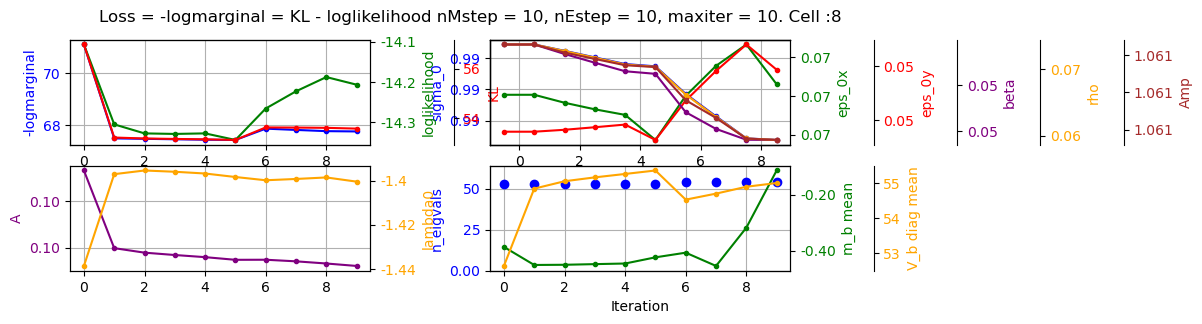

=========== New image number 14 ====================
Utility: 1.072155 |  Best image ID: 1074  | Best image index: 942

Number of inducing points: 65
Initial Loss: 72.5863
Loss iter 1: 69.4634
Loss iter 2: 69.3916
Loss iter 3: 69.3499
Loss iter 4: 69.3266
Loss iter 5: 69.3127
Loss iter 6: 69.3044
Loss iter 7: 69.2992
Loss iter 8: 69.2957
Loss iter 9: 69.2907

Time spent for E-steps:       0.302s,
Time spent for f params:      0.245s
Time spent for m update:      0.057s
Time spent for M-steps:       1.059s
Time spent for All-steps:     1.361s
Time spent computing Kernels: 0.029s
Time spent computing Loss:    0.005s

Time total after init:        1.398s
Time total before init:       1.400s
Final Loss: 69.2907


 Pietro's model: R2 = 0.43 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



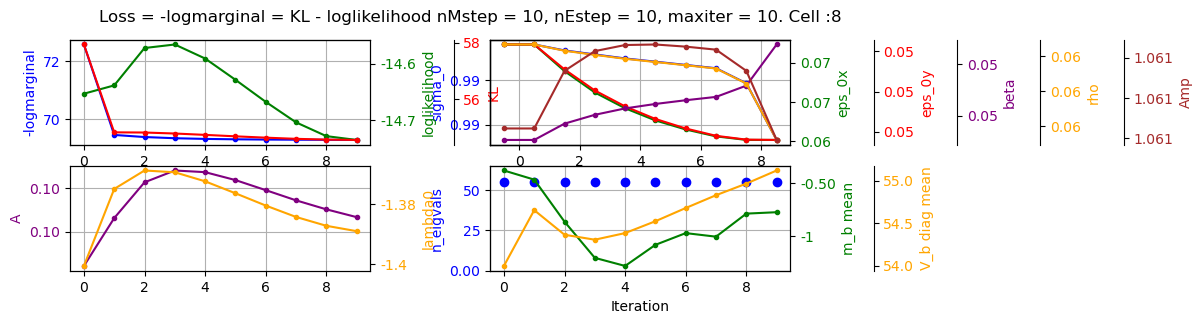

=========== New image number 15 ====================
Utility: 0.756059 |  Best image ID: 768  | Best image index: 1957

Number of inducing points: 66
Initial Loss: 73.8136
Loss iter 1: 70.9028
Loss iter 2: 70.8762
Loss iter 3: 70.8535
Loss iter 4: 70.8294
Loss iter 5: 70.7861
Loss iter 6: 70.6833
Loss iter 7: 71.0953
Loss iter 8: 71.9294
Loss iter 9: 72.3389

Time spent for E-steps:       0.310s,
Time spent for f params:      0.254s
Time spent for m update:      0.056s
Time spent for M-steps:       0.871s
Time spent for All-steps:     1.182s
Time spent computing Kernels: 0.030s
Time spent computing Loss:    0.005s

Time total after init:        1.219s
Time total before init:       1.222s
Final Loss: 72.3389


 Pietro's model: R2 = 0.40 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



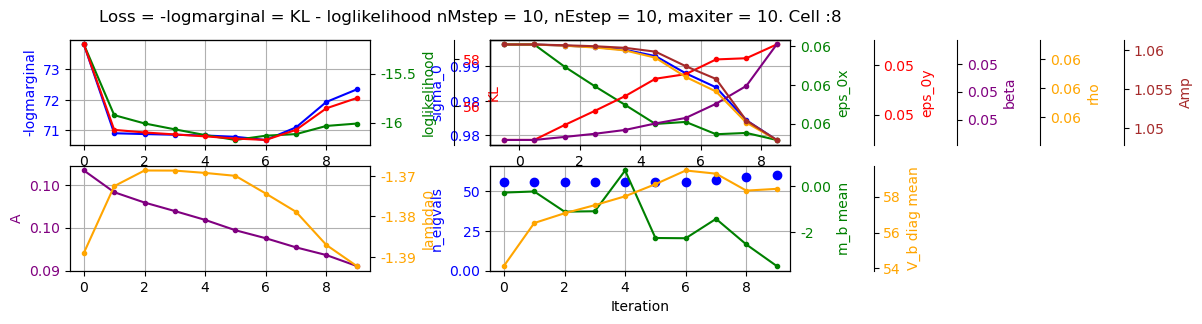

=========== New image number 16 ====================
Utility: 0.710861 |  Best image ID: 779  | Best image index: 855

Number of inducing points: 67
Initial Loss: 78.4520
Loss iter 1: 74.4128
Loss iter 2: 74.3770
Loss iter 3: 74.8455
Loss iter 4: 74.8156
Loss iter 5: 75.2819
Loss iter 6: 75.2540
Loss iter 7: 75.2269
Loss iter 8: 75.2006
Loss iter 9: 75.6910

Time spent for E-steps:       0.305s,
Time spent for f params:      0.245s
Time spent for m update:      0.059s
Time spent for M-steps:       0.893s
Time spent for All-steps:     1.198s
Time spent computing Kernels: 0.031s
Time spent computing Loss:    0.005s

Time total after init:        1.236s
Time total before init:       1.238s
Final Loss: 75.6910


 Pietro's model: R2 = 0.46 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



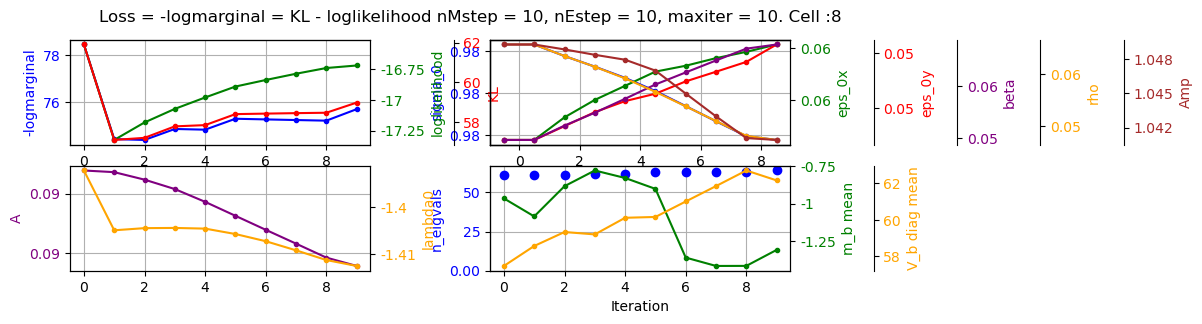

=========== New image number 17 ====================
Utility: 0.877421 |  Best image ID: 148  | Best image index: 740

Number of inducing points: 68
Initial Loss: 78.7302
Loss iter 1: 76.4210
Loss iter 2: 76.3961
Loss iter 3: 76.8709
Loss iter 4: 76.8468
Loss iter 5: 76.8220
Loss iter 6: 76.7975
Loss iter 7: 76.7734
Loss iter 8: 76.7666
Loss iter 9: 77.2464

Time spent for E-steps:       0.310s,
Time spent for f params:      0.247s
Time spent for m update:      0.064s
Time spent for M-steps:       0.968s
Time spent for All-steps:     1.279s
Time spent computing Kernels: 0.032s
Time spent computing Loss:    0.006s

Time total after init:        1.320s
Time total before init:       1.322s
Final Loss: 77.2464


 Pietro's model: R2 = 0.48 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



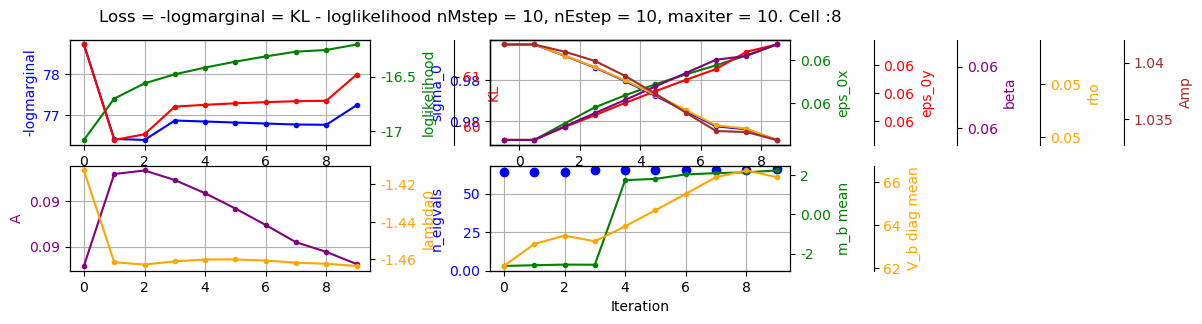

=========== New image number 18 ====================
Utility: 0.796906 |  Best image ID: 449  | Best image index: 2479

Number of inducing points: 69
Initial Loss: 82.4139
Loss iter 1: 78.6801
Loss iter 2: 78.6664
Loss iter 3: 78.6541
Loss iter 4: 78.6423
Loss iter 5: 79.1280
Loss iter 6: 79.1159
Loss iter 7: 79.1041
Loss iter 8: 79.0924
Loss iter 9: 79.0806

Time spent for E-steps:       0.312s,
Time spent for f params:      0.246s
Time spent for m update:      0.066s
Time spent for M-steps:       1.003s
Time spent for All-steps:     1.316s
Time spent computing Kernels: 0.033s
Time spent computing Loss:    0.006s

Time total after init:        1.358s
Time total before init:       1.361s
Final Loss: 79.0806


 Pietro's model: R2 = 0.51 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



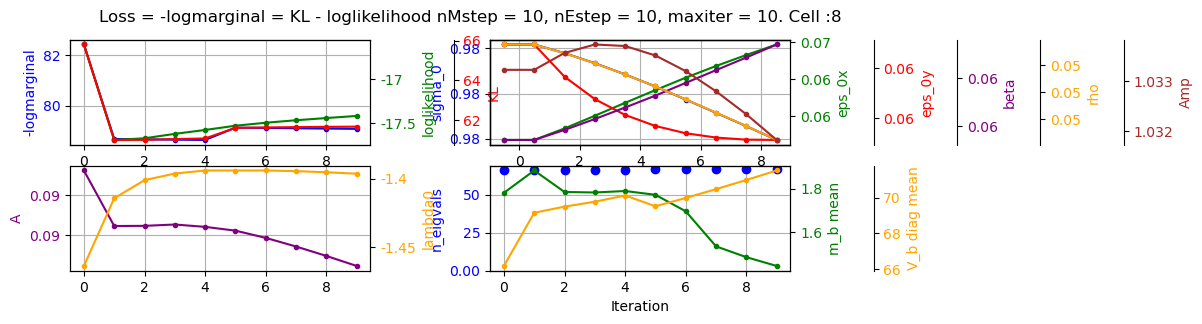

=========== New image number 19 ====================
Utility: 0.939511 |  Best image ID: 1430  | Best image index: 1474

Number of inducing points: 70
Initial Loss: 88.5856
Loss iter 1: 78.6343
Loss iter 2: 78.1449
Loss iter 3: 77.9679
Loss iter 4: 77.8857
Loss iter 5: 77.8358
Loss iter 6: 77.8020
Loss iter 7: 77.7776
Loss iter 8: 77.7570
Loss iter 9: 78.2020

Time spent for E-steps:       0.385s,
Time spent for f params:      0.318s
Time spent for m update:      0.067s
Time spent for M-steps:       0.996s
Time spent for All-steps:     1.381s
Time spent computing Kernels: 0.032s
Time spent computing Loss:    0.006s

Time total after init:        1.422s
Time total before init:       1.425s
Final Loss: 78.2020


 Pietro's model: R2 = 0.50 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



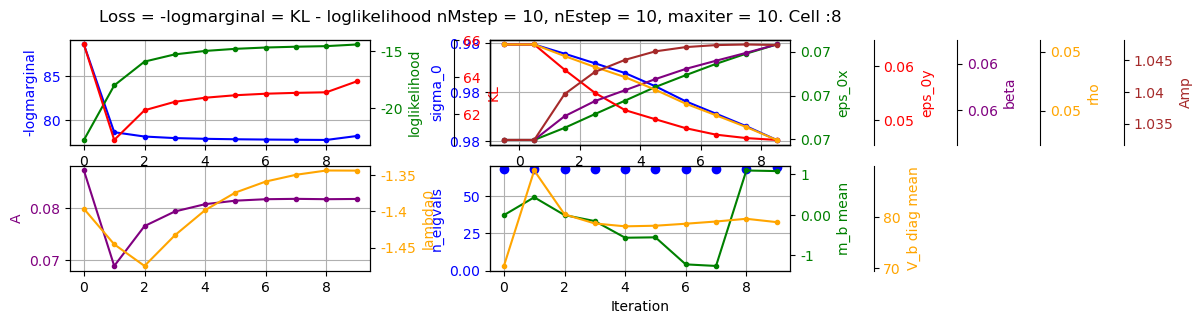

=========== New image number 20 ====================
Utility: 0.703479 |  Best image ID: 654  | Best image index: 1892

Number of inducing points: 71
Initial Loss: 91.6608
Loss iter 1: 74.3447
Loss iter 2: 73.7935
Loss iter 3: 73.5999
Loss iter 4: 73.5144
Loss iter 5: 73.4693
Loss iter 6: 73.4421
Loss iter 7: 73.4245
Loss iter 8: 73.4100
Loss iter 9: 73.3983

Time spent for E-steps:       0.384s,
Time spent for f params:      0.318s
Time spent for m update:      0.066s
Time spent for M-steps:       0.888s
Time spent for All-steps:     1.272s
Time spent computing Kernels: 0.032s
Time spent computing Loss:    0.006s

Time total after init:        1.314s
Time total before init:       1.316s
Final Loss: 73.3983


 Pietro's model: R2 = 0.53 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



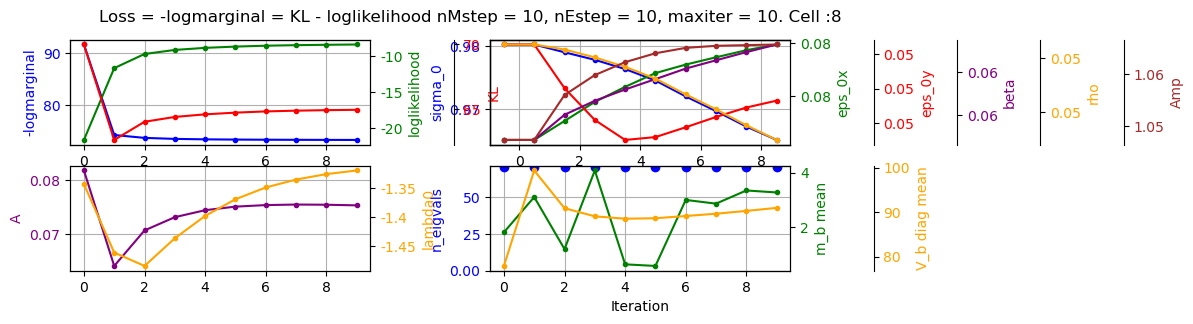

=========== New image number 21 ====================
Utility: 0.986946 |  Best image ID: 500  | Best image index: 548

Number of inducing points: 72
Initial Loss: 81.7738
Loss iter 1: 73.6158
Loss iter 2: 73.0060
Loss iter 3: 72.7575
Loss iter 4: 72.6312
Loss iter 5: 72.5539
Loss iter 6: 72.9944
Loss iter 7: 72.9421
Loss iter 8: 72.8915
Loss iter 9: 72.8428

Time spent for E-steps:       0.385s,
Time spent for f params:      0.319s
Time spent for m update:      0.066s
Time spent for M-steps:       0.936s
Time spent for All-steps:     1.321s
Time spent computing Kernels: 0.031s
Time spent computing Loss:    0.006s

Time total after init:        1.362s
Time total before init:       1.365s
Final Loss: 72.8428


 Pietro's model: R2 = 0.54 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



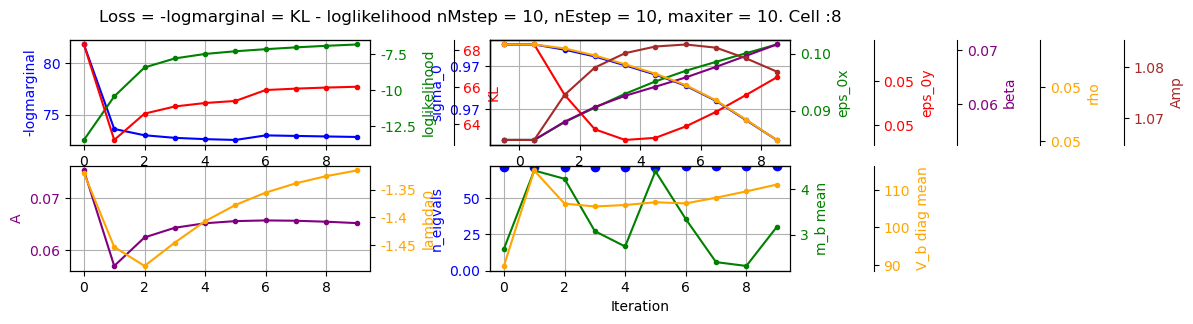

=========== New image number 22 ====================
Utility: 1.526233 |  Best image ID: 1189  | Best image index: 1067

Number of inducing points: 73
Initial Loss: 76.9437
Loss iter 1: 73.8565
Loss iter 2: 73.8196
Loss iter 3: 73.7854
Loss iter 4: 73.7436
Loss iter 5: 73.7076
Loss iter 6: 73.6693
Loss iter 7: 73.6407
Loss iter 8: 73.6025
Loss iter 9: 73.5701

Time spent for E-steps:       0.325s,
Time spent for f params:      0.257s
Time spent for m update:      0.068s
Time spent for M-steps:       1.258s
Time spent for All-steps:     1.582s
Time spent computing Kernels: 0.035s
Time spent computing Loss:    0.006s

Time total after init:        1.628s
Time total before init:       1.630s
Final Loss: 73.5701


 Pietro's model: R2 = 0.59 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



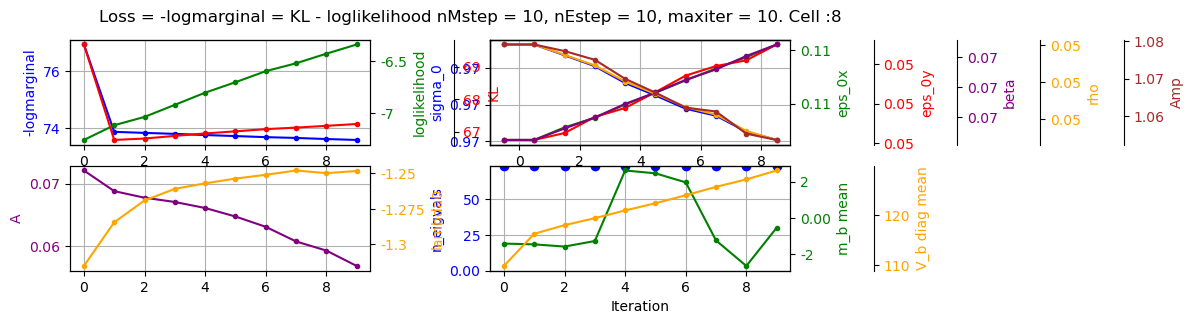

=========== New image number 23 ====================
Utility: 2.493756 |  Best image ID: 1846  | Best image index: 825

Number of inducing points: 74
Initial Loss: 79.3084
Loss iter 1: 75.6698
Loss iter 2: 75.6368
Loss iter 3: 75.5681
Loss iter 4: 75.5301
Loss iter 5: 75.4904
Loss iter 6: 75.4539
Loss iter 7: 75.4143
Loss iter 8: 75.3723
Loss iter 9: 75.3251

Time spent for E-steps:       0.345s,
Time spent for f params:      0.277s
Time spent for m update:      0.068s
Time spent for M-steps:       1.421s
Time spent for All-steps:     1.766s
Time spent computing Kernels: 0.039s
Time spent computing Loss:    0.006s

Time total after init:        1.816s
Time total before init:       1.818s
Final Loss: 75.3251


 Pietro's model: R2 = 0.59 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



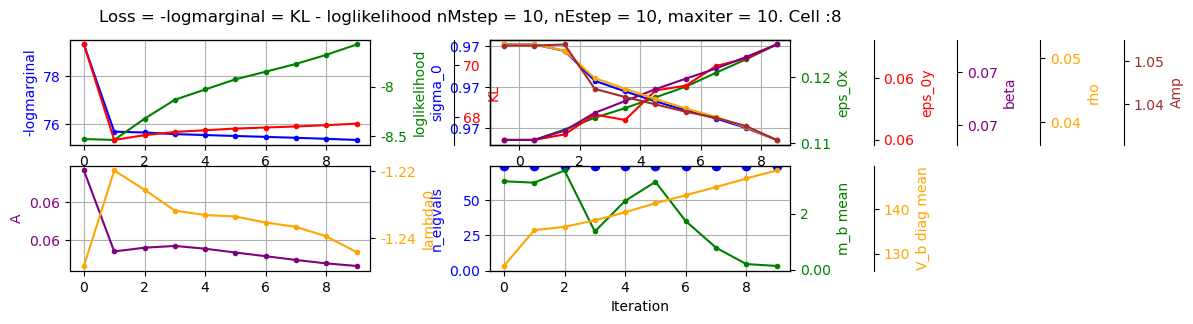

=========== New image number 24 ====================
Utility: 2.437969 |  Best image ID: 1748  | Best image index: 1423

Number of inducing points: 75
Initial Loss: 79.3897
Loss iter 1: 76.5804
Loss iter 2: 76.5226
Loss iter 3: 76.4662
Loss iter 4: 76.4164
Loss iter 5: 76.3549
Loss iter 6: 76.2615
Loss iter 7: 76.1291
Loss iter 8: 76.0273
Loss iter 9: 75.8844

Time spent for E-steps:       0.334s,
Time spent for f params:      0.267s
Time spent for m update:      0.067s
Time spent for M-steps:       2.018s
Time spent for All-steps:     2.352s
Time spent computing Kernels: 0.050s
Time spent computing Loss:    0.006s

Time total after init:        2.412s
Time total before init:       2.414s
Final Loss: 75.8844


 Pietro's model: R2 = 0.66 ± 0.02 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



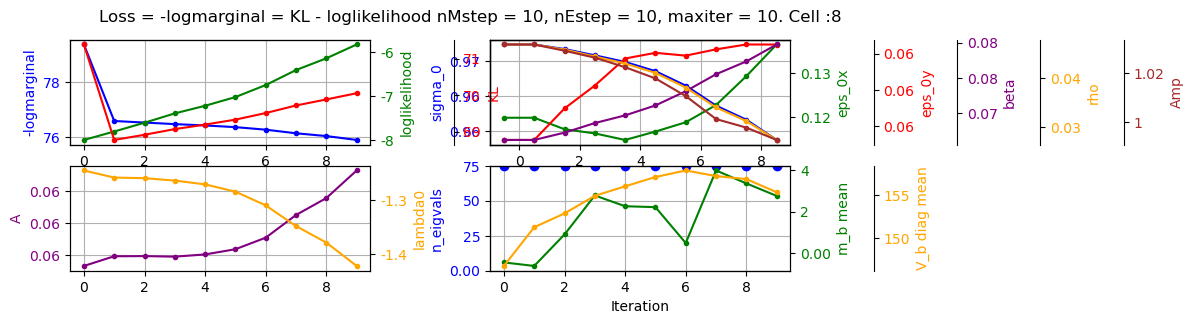

=========== New image number 25 ====================
Utility: 3.579878 |  Best image ID: 162  | Best image index: 1148

Number of inducing points: 76
Initial Loss: 83.2674
Loss iter 1: 77.8316
Loss iter 2: 77.6435
Loss iter 3: 77.5462
Loss iter 4: 77.4125
Loss iter 5: 77.3175
Loss iter 6: 77.2474
Loss iter 7: 77.1861
Loss iter 8: 77.1212
Loss iter 9: 77.0425

Time spent for E-steps:       0.351s,
Time spent for f params:      0.284s
Time spent for m update:      0.067s
Time spent for M-steps:       2.574s
Time spent for All-steps:     2.925s
Time spent computing Kernels: 0.055s
Time spent computing Loss:    0.006s

Time total after init:        2.990s
Time total before init:       2.993s
Final Loss: 77.0425


 Pietro's model: R2 = 0.61 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 10 



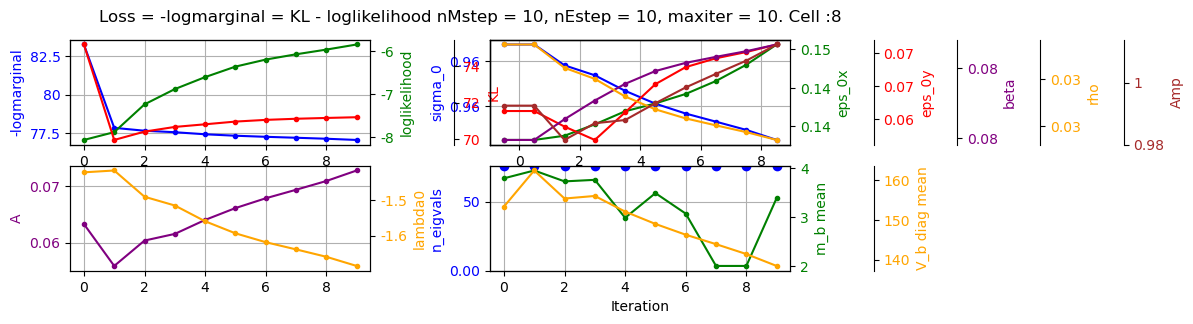

=========== New image number 26 ====================
Utility: 5.451622 |  Best image ID: 986  | Best image index: 2010

Number of inducing points: 77
Initial Loss: 80.9681
Loss iter 1: 78.3751
Loss iter 2: 78.3260
Loss iter 3: 78.2501
Loss iter 4: 78.1604
Loss iter 5: 78.0294
Loss iter 6: 77.8825
Loss iter 7: 77.7589
 ===================  Interrupted  ===================

During iteration: 7, there should be 7 completed iterations

Time spent for E-steps:       0.269s,
Time spent for f params:      0.215s
Time spent for m update:      0.054s
Time spent for M-steps:       2.089s
Time spent for All-steps:     2.358s
Time spent computing Kernels: 0.044s
Time spent computing Loss:    0.004s

Time total after init:        2.673s
Time total before init:       2.676s
Final Loss: 77.8825
Error in the fit


KeyboardInterrupt: 

In [11]:
torch.set_grad_enabled(False)

active_model = copy.deepcopy(start_model)

for j in range(250):
    print(f'=========== New image number {j} ====================')

    # region __________ Retreive the values from the last model fit __________
    in_use_idx    = active_model['fit_parameters']['in_use_idx']
    xtilde_idx    = active_model['fit_parameters']['xtilde_idx']

    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]

    xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

    xstar  = X_remaining

    kernfun       = active_model['fit_parameters']['kernfun']
    if kernfun == 'acosker': kernfun = utils.acosker
    n_px_side     = active_model['fit_parameters']['n_px_side']
    EIGVAL_TOL    = active_model['fit_parameters']['eigval_tol']

    final_kernel  = active_model['final_kernel']
    
    mask          = active_model['mask']
    C             = active_model['C']
    B             = active_model['B']
    K_tilde_b     = active_model['K_tilde_b']
    K_tilde_inv_b = active_model['K_tilde_inv_b']
    K_b           = active_model['K_b']
    Kvec          = active_model['Kvec']
    m_b           = active_model['m_b']
    V_b           = active_model['V_b']    
    f_params      = active_model['f_params']
    theta         = active_model['hyperparams_tuple'][0]
    A             = torch.exp(f_params['logA'])
    lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']
    
    theta_lower_lims  = active_model['hyperparams_tuple'][1]
    theta_higher_lims = active_model['hyperparams_tuple'][2]

    # endregion

    # region __________ Calculate the loglikelihood on the 1000 Test set __________
    Kvec_test = kernfun(theta, X_test_1000[:,mask], x2=None, C=C, dC=None, diag=True)
    K_test    = kernfun(theta, X_test_1000[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    K_test_b  = K_test @ B 

    lambda_m_t, lambda_var_t = utils.lambda_moments( X_test_1000[:,mask], K_tilde_b, K_test_b@K_tilde_inv_b, Kvec_test, K_test_b, C, m_b, V_b, theta)

    f_mean = utils.mean_f_given_lambda_moments( f_params, lambda_m_t, lambda_var_t)

    utils.compute_loglikelihood( R_test_1000,  f_mean, lambda_m_t, lambda_var_t, f_params )[0] 
    # endregion

    # region __________ Calculate the utility of each remaining image __________
    # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
    Kvec_star = kernfun(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
    K_star    = kernfun(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
    K_star_b  = K_star @ B 

    lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta)  

    logf_mean = A*lambda_m_t + lambda0
    logf_var  = A**2 * lambda_var_t

    # Estimate the utility and cap the maximum r ( used in a summation to infinity )
    r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
    u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )

    i_best   = u2d.argmax()                 # Index of the best image in the utility vector
    x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
    print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

    if x_idx_best in in_use_idx :
        raise ValueError('The best image is already in use or in the test set')
    if x_idx_best in test_1000_idx:
        raise ValueError('The best image is in the test set')
    
    # endregion

    # region __________ Update indices and Kernels __________ 
    # Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
    in_use_idx    = torch.cat( (in_use_idx, x_idx_best[None]))
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    X_in_use    = X[in_use_idx]
    R_in_use    = R[in_use_idx] 
    X_remaining = X[remaining_idx]
    R_remaining = R[remaining_idx]
    # # The added images are used as inducing points as long as the number of inducing points is less than 200
    # # if in_use_idx.shape[0] < 200:
    xtilde_idx     = in_use_idx
    ntilde         = xtilde_idx.shape[0]
    nt             = X_in_use.shape[0]
    # We add it as the last row. This is not ensured if we use X[xtilde_idx] instead of xtilde
    xtilde_updated = X[xtilde_idx]
    # xtilde_updated = torch.cat((xtilde, X[x_idx_best][None,:]), axis=0) 

    active_model['xtilde']                       = xtilde_updated
    active_model['fit_parameters']['ntilde']     = ntilde
    active_model['fit_parameters']['in_use_idx'] = in_use_idx
    active_model['fit_parameters']['xtilde_idx'] = xtilde_idx

    # __________ Update variational parameters
    # To update the variational parameters to the new dimensionality we need to pass through the original space. 
    # V and m will be projected onto the right eigenspace in varGP using the last used B.
    V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
    V = 0.5*(V + V.T)    # Ensure symmetry
    m = B @ m_b          # shape (ntilde-1,)

    V_new = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
    V_new[:ntilde-1, :ntilde-1] = V       

    active_model['V'] = V_new 
    active_model['m'] = torch.cat( (m, m.mean()[None]))

    # __________ Update kernel matrices by only computing their latest column
    init_kernel = {}
    C                     = final_kernel['C']
    mask                  = final_kernel['mask']
    K_tilde_reduced       = final_kernel['K_tilde']            # We call it reduced because its still the Ktilde used in the last iteration
    K_reduced             = final_kernel['K']           
    P                     = final_kernel['eigvecs']            # Projection matrix to the complete eigenspace

    #100 computattions of K_tilde this way take ~0.03s.
    K_tilde_column  = kernfun(theta, xtilde_updated[:,mask], xtilde_updated[-1,mask][None], C=C, dC=None, diag=False) 
    K_tilde         = torch.cat((K_tilde_reduced, K_tilde_column[:-1]), axis=1)
    K_tilde         = torch.cat((K_tilde, K_tilde_column.T), axis=0)  

    if ntilde==nt: K = K_tilde
    else: raise NotImplementedError('Fast calculation of K not implemented for ntilde != ntrain')

    Kvec            = kernfun(theta, X_in_use[:,mask],x2=None, C=C, dC=None, diag=True)   
    # endregion

    # region __________ Project the matrices in the eigenspace of the largest eigenvectors __________
    eigvals, eigvecs = torch.linalg.eigh(K_tilde, UPLO='L')                                # calculates the eigenvals for an assumed symmetric matrix, eigenvalues  are returned in ascending order. Uplo=L uses the lower triangular part of the matrix. Eigenvectors are columns
    ikeep            = eigvals > max(eigvals.max() * EIGVAL_TOL, EIGVAL_TOL)                          # Keep only the largest eigenvectors
    B                = eigvecs[:, ikeep]                                     
    # make K_tilde_b and K_b a projection of K_tilde and K into the eigenspace of the largest eigenvectors
    K_tilde_b        = torch.diag(eigvals[ikeep])                    
    K_b              = K @ B                                         
    
    K_tilde_inv_b = torch.diag_embed(1/eigvals[ikeep])        
    KKtilde_inv_b = B if ntilde==nt else K_b @ K_tilde_inv_b
    # endregion

    # region __________ Save the updated kernel to a dict to feed to the model __________
    init_kernel['C']                 = C
    init_kernel['mask']              = mask
    init_kernel['K_tilde']           = K_tilde
    init_kernel['K']                 = K
    init_kernel['Kvec']              = Kvec
    init_kernel['B']                 = B
    init_kernel['K_tilde_b']         = K_tilde_b
    init_kernel['K_b']               = K_b
    init_kernel['K_tilde_inv_b']     = K_tilde_inv_b
    init_kernel['KKtilde_inv_b']     = KKtilde_inv_b

    print(f'\nNumber of inducing points: {ntilde}')


    active_model['init_kernel']      = init_kernel        # We update the model after copy because deepcopy doesnt work if 'init_kernel' is a key
    # endregion
    
    # region __________ Fit new model __________

    if j == 2:
        pass


    prev_active_model = copy.deepcopy(active_model)
    active_model, err_dict = utils.varGP(X_in_use, R_in_use, **active_model)

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']

    spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )

    utils.plot_loss_and_theta_notebook(active_model, figsize=(8,3), marker='.')#ylim_logmarg=(0, 5000))

    pass
    # endregion
    
    # region __________ Test the model r squared and log likelihood on the two test set __________
    
    # if torch.any(torch.isnan(r2)):
    #     print('r2 is nan')
    #     raise ValueError('r2 is nan')

    # r2_vec.append(r2)
    # loss_vec.append(-active_model['values_track']['loss_track']['logmarginal'][-1])

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )

utils.plot_loss_and_theta_notebook(active_model, figsize=(8,3), marker='.')#ylim_logmarg=(0, 5000))



### Random training loop

In [ ]:
torch.set_grad_enabled(False)

loglk_test_1000_dict = {}

for p in range(10):

    print(f'=========== Active loop : Initial condition number {p} ====================')

    #region

    rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

    cellid       = 8         # Choose cell
    ntrain_start = 50        # Number of first training data points

    kernfun      = 'acosker' # Choose kernel function

    nEstep       = 10         # Total number of E-steps iterations.
    nFparamstep  = 10  
    nMstep       = 10         # Total number of M-steps iterations. 
    maxiter      = 10         # Iterations of the optimization algorithm comprising M and E steps

    ntilde       = ntrain_start

    # Choose a random subset of the data and save the idx
    all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
    torch.manual_seed(p)
    torch.cuda.manual_seed(p)
    all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

    test_1000_idx = all_idx_perm[-1000:]                                     # These will be the indices of the test set
    all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
    rndm_idx      = all_idx_perm[:ntrain_start]                              # These will be the indices of the initial training. This way ensures not repetitions.


    start_idx     = rndm_idx
    # start_idx     = rndm_idx.sort()[0]
    in_use_idx    = start_idx
    xtilde_idx    = in_use_idx
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]
    # remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    # Set the starting set
    xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
    X_in_use      = X[in_use_idx,:]
    X_remaining   = X[remaining_idx,:]
    X_test_1000   = X[test_1000_idx,:]

    R_remaining   = R[remaining_idx]
    R_in_use      = R[in_use_idx]
    R_test_1000   = R[test_1000_idx]


    logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
    logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

    sigma_0    = torch.tensor(1.0)
    Amp        = torch.tensor(1.0) 
    eps_0x     = torch.tensor(0.0001)
    eps_0y     = torch.tensor(0.0001)
    # Hypermarameters, if needed to be set manually
    theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

    # Set the gradient of the hyperparemters to be updatable 
    for key, value in theta.items(): # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
        theta[key] = value.requires_grad_()

    # If hyperparameters are set manually:

    hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=False, **theta)
    # If hyperparameters are set based on the STAs:
    # hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

    A        = torch.tensor(0.01)
    logA     = torch.log(A)
    # lambda0  = torch.tensor(0.31)
    lambda0  = torch.tensor(1.)
    f_params = {'logA': logA, 'lambda0':lambda0}
    f_params['logA'] = f_params['logA'].requires_grad_() # The optimal lambda0 is given with a fixed A.

    fit_parameters = {'ntilde':      ntilde,
                    'maxiter':     maxiter,
                    'nMstep':      nMstep,
                    'nEstep':      nEstep,
                    'nFparamstep': nFparamstep,
                    'kernfun':     kernfun,
                    'cellid':      cellid,
                    'n_px_side':   n_px_side,
                    'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                    'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                    'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

    init_model = {
            'fit_parameters':    fit_parameters,
            'xtilde':            xtilde_start,
            'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
            'f_params':          f_params,
            # 'm':                 torch.zeros( (ntilde) )
            # 'm': torch.ones( (ntilde) )
            #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
        }
    
    fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

    # Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
    start_model = fit_model

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']

    #endregion

    random_model = copy.deepcopy(start_model)
    # random_model = copy.deepcopy(start_model)
    # fit_model = copy.deepcopy(prev_model)

    r2_vec = []
    loss_vec = []
    loglk_test_1000 = [None]*250
    threads = []
    saved_time = [0]


    for j in range(250):
        print(f'=========== Active Loop number: {p}, New image number {j} ====================')

        # region __________ Retreive the values from the last model fit __________
        in_use_idx    = random_model['fit_parameters']['in_use_idx']
        xtilde_idx    = random_model['fit_parameters']['xtilde_idx']

        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

        xstar  = X_remaining

        kernfun       = random_model['fit_parameters']['kernfun']
        if kernfun == 'acosker': kernfun = utils.acosker
        n_px_side     = random_model['fit_parameters']['n_px_side']
        EIGVAL_TOL    = random_model['fit_parameters']['eigval_tol']

        final_kernel  = random_model['final_kernel']
        
        mask          = random_model['mask']
        C             = random_model['C']
        B             = random_model['B']
        K_tilde_b     = random_model['K_tilde_b']
        K_tilde_inv_b = random_model['K_tilde_inv_b']
        K_b           = random_model['K_b']
        Kvec          = random_model['Kvec']
        m_b           = random_model['m_b']
        V_b           = random_model['V_b']    
        f_params      = random_model['f_params']
        theta         = random_model['hyperparams_tuple'][0]
        A             = torch.exp(f_params['logA'])
        lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']
        
        theta_lower_lims  = random_model['hyperparams_tuple'][1]
        theta_higher_lims = random_model['hyperparams_tuple'][2]

        # endregion

        # region __________ Calculate the loglikelihood on the 1000 Test set __________

        
        # Kvec_test = kernfun(theta, X_test_1000[:,mask], x2=None, C=C, dC=None, diag=True)
        # K_test    = kernfun(theta, X_test_1000[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
        # K_test_b  = K_test @ B 

        # lambda_m_t, lambda_var_t = utils.lambda_moments( X_test_1000[:,mask], K_tilde_b, K_test_b@K_tilde_inv_b, Kvec_test, K_test_b, C, m_b, V_b, theta)

        # f_mean = utils.mean_f_given_lambda_moments( f_params, lambda_m_t, lambda_var_t)

        # loglk_test_1000.append( utils.compute_loglikelihood( R_test_1000,  f_mean, lambda_m_t, lambda_var_t, f_params )[0] )  

        print(f" loglk_test_1000[{j}]: {loglk_test_1000[j]} before threading")

        def calculate_loglikelihood_thread(X_test_1000, R_test_1000, xtilde, B, K_tilde_b, K_tilde_inv_b, C, m_b, V_b, theta, f_params, mask, kernfun, loglk_test_1000, index):
            start_time_thread = time.time()
            Kvec_test = kernfun(theta, X_test_1000[:,mask], x2=None, C=C, dC=None, diag=True)
            K_test    = kernfun(theta, X_test_1000[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
            K_test_b  = K_test @ B 

            lambda_m_t, lambda_var_t = utils.lambda_moments(X_test_1000[:,mask], K_tilde_b, K_test_b@K_tilde_inv_b, Kvec_test, K_test_b, C, m_b, V_b, theta)

            f_mean = utils.mean_f_given_lambda_moments(f_params, lambda_m_t, lambda_var_t)

            loglk_test_1000[index] = utils.compute_loglikelihood(R_test_1000, f_mean, lambda_m_t, lambda_var_t, f_params)[0] 

            print(f" loglk_test_1000[{index}]: {loglk_test_1000[index]} inside threading") 
            saved_time[0] = time.time() - start_time_thread

        thread = threading.Thread(target=calculate_loglikelihood_thread, args=(X_test_1000, R_test_1000, xtilde, B, K_tilde_b, K_tilde_inv_b, C, 
                                                                               m_b, V_b, theta, f_params, mask, kernfun, loglk_test_1000, j))
        threads.append(thread)
        thread.start()

        # endregion

        # region __________ Calculate the utility of each remaining image __________
        # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
        Kvec_star = kernfun(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
        K_star    = kernfun(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
        K_star_b  = K_star @ B 

        lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta)  

        logf_mean = A*lambda_m_t + lambda0
        logf_var  = A**2 * lambda_var_t

        # Estimate the utility and cap the maximum r ( used in a summation to infinity )
        r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
        u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )

        # i_best   = u2d.argmax()                 # Index of the best image in the utility vector
        i_best = torch.randint(0, u2d.shape[0], (1,)).item()
        x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
        print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

        if x_idx_best in in_use_idx :
            raise ValueError('The best image is already in use or in the test set')
        if x_idx_best in test_1000_idx:
            raise ValueError('The best image is in the test set')
        
        # endregion

        # region __________ Update indices and Kernels __________ 
        # Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
        in_use_idx    = torch.cat( (in_use_idx, x_idx_best[None]))
        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

        X_in_use    = X[in_use_idx]
        R_in_use    = R[in_use_idx] 
        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]
        # # The added images are used as inducing points as long as the number of inducing points is less than 200
        # # if in_use_idx.shape[0] < 200:
        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        nt             = X_in_use.shape[0]
        # We add it as the last row. This is not ensured if we use X[xtilde_idx] instead of xtilde
        xtilde_updated = X[xtilde_idx]
        # xtilde_updated = torch.cat((xtilde, X[x_idx_best][None,:]), axis=0) 

        random_model['xtilde']                       = xtilde_updated
        random_model['fit_parameters']['ntilde']     = ntilde
        random_model['fit_parameters']['in_use_idx'] = in_use_idx
        random_model['fit_parameters']['xtilde_idx'] = xtilde_idx

        # __________ Update variational parameters
        # To update the variational parameters to the new dimensionality we need to pass through the original space. 
        # V and m will be projected onto the right eigenspace in varGP using the last used B.
        V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
        V = 0.5*(V + V.T)    # Ensure symmetry
        m = B @ m_b          # shape (ntilde-1,)

        V_new = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
        V_new[:ntilde-1, :ntilde-1] = V       

        random_model['V'] = V_new 
        random_model['m'] = torch.cat( (m, m.mean()[None]))

        # __________ Update kernel matrices by only computing their latest column
        init_kernel = {}
        C                     = final_kernel['C']
        mask                  = final_kernel['mask']
        K_tilde_reduced       = final_kernel['K_tilde']            # We call it reduced because its still the Ktilde used in the last iteration
        K_reduced             = final_kernel['K']           
        P                     = final_kernel['eigvecs']            # Projection matrix to the complete eigenspace

        #100 computattions of K_tilde this way take ~0.03s.
        K_tilde_column  = kernfun(theta, xtilde_updated[:,mask], xtilde_updated[-1,mask][None], C=C, dC=None, diag=False) 
        K_tilde         = torch.cat((K_tilde_reduced, K_tilde_column[:-1]), axis=1)
        K_tilde         = torch.cat((K_tilde, K_tilde_column.T), axis=0)  

        if ntilde==nt: K = K_tilde
        else: raise NotImplementedError('Fast calculation of K not implemented for ntilde != ntrain')

        Kvec            = kernfun(theta, X_in_use[:,mask],x2=None, C=C, dC=None, diag=True)   
        # endregion

        # region __________ Project the matrices in the eigenspace of the largest eigenvectors __________
        eigvals, eigvecs = torch.linalg.eigh(K_tilde, UPLO='L')                                # calculates the eigenvals for an assumed symmetric matrix, eigenvalues  are returned in ascending order. Uplo=L uses the lower triangular part of the matrix. Eigenvectors are columns
        ikeep            = eigvals > max(eigvals.max() * EIGVAL_TOL, EIGVAL_TOL)                          # Keep only the largest eigenvectors
        B                = eigvecs[:, ikeep]                                     
        # make K_tilde_b and K_b a projection of K_tilde and K into the eigenspace of the largest eigenvectors
        K_tilde_b        = torch.diag(eigvals[ikeep])                    
        K_b              = K @ B                                         
        
        K_tilde_inv_b = torch.diag_embed(1/eigvals[ikeep])        
        KKtilde_inv_b = B if ntilde==nt else K_b @ K_tilde_inv_b
        # endregion

        # region __________ Save the updated kernel to a dict to feed to the model __________
        init_kernel['C']                 = C
        init_kernel['mask']              = mask
        init_kernel['K_tilde']           = K_tilde
        init_kernel['K']                 = K
        init_kernel['Kvec']              = Kvec
        init_kernel['B']                 = B
        init_kernel['K_tilde_b']         = K_tilde_b
        init_kernel['K_b']               = K_b
        init_kernel['K_tilde_inv_b']     = K_tilde_inv_b
        init_kernel['KKtilde_inv_b']     = KKtilde_inv_b

        print(f'Number of inducing points: {ntilde}')
        print(f'Number of images used:     {in_use_idx.shape[0]}')

        random_model['init_kernel']      = init_kernel        # We update the model after copy because deepcopy doesnt work if 'init_kernel' is a key
        # endregion
        
        # region __________ Fit new model __________
        prev_random_model = copy.deepcopy(random_model)
        random_model, err_dict = utils.varGP(X_in_use, R_in_use, **random_model)

        if err_dict['is_error']:
            print('Error in the fit')
            raise err_dict['error']

        # endregion
        
        # region __________ Test the model r squared and log likelihood on the two test set __________

        # Wait for thread
        
        # if torch.any(torch.isnan(r2)):
        #     print('r2 is nan')
        #     raise ValueError('r2 is nan')

        # r2_vec.append(r2)
        # loss_vec.append(-random_model['values_track']['loss_track']['logmarginal'][-1])

        for thread in threads:
            thread.join()
        print(f" loglk_test_1000[j]: {loglk_test_1000[j]} after threads joining, saved time: {saved_time[0]:.4f}")

    spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **random_model )

    # utils.plot_loss_and_theta_notebook(random_model, figsize=(15,10), marker='.')#ylim_logmarg=(0, 5000))

    # loglk_test_1000_dict[f'{p} initial condition Random Model'] = loglk_test_1000

Using device: cuda:0 (from utils.py)
=========== Active loop : Initial condition number 0 ====================
Initial Loss: 116.8382
Loss iter 1: 74.6614
Loss iter 2: 73.4755
Loss iter 3: 71.4212
Loss iter 4: 69.7452
Loss iter 5: 68.1920
Loss iter 6: 66.9367
Loss iter 7: 66.0529
Loss iter 8: 65.3716
Loss iter 9: 64.9230

Time spent for E-steps:       8.998s,
Time spent for f params:      8.908s
Time spent for m / V update:  0.090s
Time spent for M-steps:       1.771s
Time spent for All-steps:     10.768s
Time spent computing Kernels: 0.059s
Time spent computing Loss:    0.027s

Time total after init:        10.860s
Time total before init:       10.872s
Final Loss: 64.9230
=========== Active Loop number: 0, New image number 0 ====================
 loglk_test_1000[0]: None before threading
 loglk_test_1000[0]: -1632.8414375408163 inside threading
Utility: 0.117727 |  Best image ID: 641  | Best image index: 2732
Number of inducing points: 51
Number of images used:     51
Initial Loss: 68

Traceback (most recent call last):
  File "/home/idv-eqs8-pza/anaconda3/envs/pytorch/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2941715/3842799941.py", line 322, in <module>
    raise err_dict['error']
  File "/home/idv-eqs8-pza/IDV_code/Variational_GP/Gaussian-Processes/Spatial_GP_repo/utils.py", line 1932, in varGP
    optimizer_f_params.step(closure_f_params)
  File "/home/idv-eqs8-pza/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/optimizer.py", line 373, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/idv-eqs8-pza/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/idv-eqs8-pza/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lbfgs.py", line 429, in step

In [ ]:
loglk_test_1000_dict.keys()
# with open(f'/home/idv-eqs8-pza/IDV_code/Variational_GP/Gaussian-Processes/Spatial_GP_repo/models') as f:
with open(f'/home/idv-eqs8-pza/IDV_code/Variational_GP/Gaussian-Processes/Spatial_GP_repo/models/loglk_test_1000_dict_cell{cellid}_random.pkl', 'wb') as f:

    pickle.dump(loglk_test_1000_dict, f)

#### Compare the performance of different sequences images ( random and active )

### Compare 8 different models ( choosing different starting models each time )

In [ ]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)

n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials

active_models_r2 = []
random_models_r2 = []
active_models_loss = []
random_models_loss = []


for i in range(8): # We change the random seed to get different starting points
    # region Initialize starting model

    # Choose a random subset of the data and save the idx
    all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
    torch.manual_seed(i)
    torch.cuda.manual_seed(i)
    all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

    test_1000_idx = all_idx_perm[-1000:]                                     # These will be the indices of the test set
    all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
    rndm_idx      = all_idx_perm[:ntrain_start]                              # These will be the indices of the initial training. This way ensures not repetitions.


    start_idx     = rndm_idx.sort()[0]
    in_use_idx    = start_idx
    xtilde_idx    = in_use_idx
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

    # Set the starting set
    xtilde_start  = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
    X_in_use      = X[in_use_idx,:]
    X_remaining   = X[remaining_idx,:]
    X_test_1000   = X[test_1000_idx,:]

    R_remaining   = R[remaining_idx]
    R_in_use      = R[in_use_idx]
    R_test_1000   = R[test_1000_idx]

    # endregion

    # region Initialize hyperparameters
        # For details on the hyperparameters choice see one_cell_fit.ipynb
    logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
    logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

    sigma_0    = torch.tensor(1.0)
    Amp        = torch.tensor(1.0) 
    eps_0x     = torch.tensor(0.0001)
    eps_0y     = torch.tensor(0.0001)
    # Hypermarameters, if needed to be set manually
    theta = {'sigma_0': sigma_0, 'Amp': Amp, 'eps_0x':eps_0x, 'eps_0y':eps_0y, '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr,  }

    # Set the gradient of the hyperparemters to be updatable 
    for key, value in theta.items():
        # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nmstep=0 and dont do the M-step)
        # if key == 'Amp':
            # continue
        theta[key] = value.requires_grad_()

    # If hyperparameters are set manually:
    # theta = prev_theta
    hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
    # If hyperparameters are set based on the STAs:
    # hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)

    A        = torch.tensor(0.01)
    logA     = torch.log(A)
    # lambda0  = torch.tensor(0.31)
    lambda0  = torch.tensor(1.)
    # f_params = {'logA': logA, 'loglambda0':torch.log(lambda0)}
    f_params = {'logA': logA, 'lambda0':lambda0}

    for key, value in f_params.items():
        f_params[key] = value.requires_grad_()

    fit_parameters = {'ntilde':      ntilde,
                    'maxiter':     maxiter,
                    'nMstep':      nMstep,
                    'nEstep':      nEstep,
                    'nFparamstep': nFparamstep,
                    'kernfun':     kernfun,
                    'cellid':      cellid,
                    'n_px_side':   n_px_side,
                    'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                    'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                    'start_idx':   start_idx }     # Indexes used to generate the initial training set, same as the starting xtilde

    init_model = {
            'fit_parameters':    fit_parameters,
            'xtilde':            xtilde_start,
            'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
            'f_params':          f_params,
            # 'm':                 torch.zeros( (ntilde) )
            # 'm': torch.ones( (ntilde) )
            #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
        }

    # endregion

    # region Fit the starting model

    fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

    # Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
    start_model = fit_model

    if err_dict['is_error']:
        print('Error in the fit')
        raise err_dict['error']
    
    # Save the model
    utils.save_model(start_model, f'models/starting_models_active_learning/iter_{i}', additional_description='Starting model for active learning')

    # endregion
    
    active_model = copy.deepcopy(start_model)
    random_model = copy.deepcopy(start_model)

    r2_vec = []
    r2_vec2 = []
    loss_vec = []
    loss_vec2 = []


    for j in range(150):
        print(f'=========== New image number {j} for iteration {i} ====================')

        # region ________ Active model __________
        in_use_idx    = active_model['fit_parameters']['in_use_idx']
        xtilde_idx    = active_model['fit_parameters']['xtilde_idx']

        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

        xstar  = X_remaining

        kernfun       = active_model['fit_parameters']['kernfun']
        mask          = active_model['mask']
        C             = active_model['C']
        B             = active_model['B']
        K_tilde_b     = active_model['K_tilde_b']
        K_tilde_inv_b = active_model['K_tilde_inv_b']
        K_b           = active_model['K_b']
        Kvec          = active_model['Kvec']
        m_b           = active_model['m_b']
        V_b           = active_model['V_b']    
        f_params      = active_model['f_params']
        theta         = active_model['hyperparams_tuple'][0]
        A             = torch.exp(f_params['logA'])
        lambda0       = torch.exp(f_params['loglambda0']) if 'loglambda0' in f_params else f_params['lambda0']

        # Calculate the matrices to compute the lambda moments. They are referred to the unseen images xstar
        Kvec_star = utils.acosker(theta, xstar[:,mask], x2=None, C=C, dC=None, diag=True)
        K_star    = utils.acosker(theta, xstar[:,mask], x2=xtilde[:,mask], C=C, dC=None, diag=False)
        K_star_b  = K_star @ B 

        lambda_m_t, lambda_var_t = utils.lambda_moments( xstar[:,mask], K_tilde_b, K_star_b@K_tilde_inv_b, Kvec_star, K_star_b, C, m_b, V_b, theta, kernfun)  

        logf_mean = A*lambda_m_t + lambda0
        logf_var  = A**2 * lambda_var_t

        # Estimate the utility and cap the maximum r ( used in a summation to infinity )
        r_masked = torch.arange(0, 100, dtype=TORCH_DTYPE)
        u2d      = utils.nd_utility(logf_var, logf_mean, r_masked )

        i_best   = u2d.argmax()                 # Index of the best image in the utility vector
        x_idx_best   = remaining_idx[i_best]    # Index of the best image in the dataset indices
        print(f'Utility: {u2d[i_best].item():<8.6f} |  Best image ID: {i_best}  | Best image index: {x_idx_best}')

        if x_idx_best in in_use_idx :
            raise ValueError('The best image is already in use or in the test set')
        if x_idx_best in test_1000_idx:
            raise ValueError('The best image is in the test set')
        

        # Update the remaining and to_be_used indices. Always sort the indices. We also update the remaining only to have consistency, not cause they are used here
        # in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_best[None]))).sort()[0]  
        # remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_in_use    = X[in_use_idx]
        R_in_use    = R[in_use_idx] 
        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]
        # # The added images are used as inducing points as long as the number of inducing points is less than 200
        # # if in_use_idx.shape[0] < 200:
        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

        active_model['xtilde']                       = xtilde_updated
        active_model['fit_parameters']['ntilde']     = ntilde
        active_model['fit_parameters']['in_use_idx'] = in_use_idx
        active_model['fit_parameters']['xtilde_idx'] = xtilde_idx

        # To update the variational parameters to the new dimensionality we need to pass through the original space. 
        # V and m will be projected onto the right eigenspace in varGP. 
        V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
        V = 0.5*(V + V.T)    # Ensure symmetry
        m = B @ m_b          # shape (ntilde-1,)

        V_new   = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)#*lambda_var_t[i_best]
        V_new[:ntilde-1, :ntilde-1] = V       

        active_model['V'] = V_new 
        active_model['m'] = torch.cat( (m, m.mean()[None]))
        # active_model['m'] = torch.cat( (m, lambda_m_t[i_best][None]))  

        print(f'Number of inducing points: {ntilde}')
        print(f'Number of images used:     {in_use_idx.shape[0]}')


        prev_active_model = copy.deepcopy(active_model)

        active_model, err_dict = utils.varGP(X_in_use, R_in_use, **active_model)

        if err_dict['is_error']:
            print('Error in the fit')
            raise err_dict['error']

        spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **active_model )

        if torch.any(torch.isnan(r2)):
            print('r2 is nan')
            raise ValueError('r2 is nan')

        r2_vec.append(r2)
        loss_vec.append(-active_model['values_track']['loss_track']['logmarginal'][-1])
        # endregion

        # region _______ Random model __________
        
        in_use_idx    = random_model['fit_parameters']['in_use_idx']
        xtilde_idx    = random_model['fit_parameters']['xtilde_idx']

        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde = X[xtilde_idx]  # This has to be the same as start_model['xtilde']

        i_random     = torch.randint(0, X_remaining.shape[0], (1,))[0]
        x_idx_random = remaining_idx[i_random]  # Index of the best image in the dataset indices

        in_use_idx    = torch.unique(torch.cat( (in_use_idx, x_idx_random[None]))).sort()[0]  
        remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

        X_in_use    = X[in_use_idx]
        R_in_use    = R[in_use_idx] 
        X_remaining = X[remaining_idx]
        R_remaining = R[remaining_idx]

        xtilde_idx     = in_use_idx
        ntilde         = xtilde_idx.shape[0]
        xtilde_updated = X[xtilde_idx]                                          # Same as X_in_use

        B                                            = random_model['B']
        m_b                                          = random_model['m_b']
        V_b                                          = random_model['V_b'] 
        random_model['xtilde']                       = xtilde_updated
        random_model['fit_parameters']['ntilde']     = ntilde
        random_model['fit_parameters']['in_use_idx'] = in_use_idx
        random_model['fit_parameters']['xtilde_idx'] = xtilde_idx

        V = B @ V_b @ B.T    # shape (ntilde-1, ntilde-1)
        V = 0.5*(V + V.T)    # Ensure symmetry
        m = B @ m_b          # shape (ntilde-1,)

        V_new   = torch.eye(ntilde, dtype=V_b.dtype, device=V_b.device)
        V_new[:ntilde-1, :ntilde-1] = V       

        random_model['V'] = V_new 
        random_model['m'] = torch.cat( (m, m.mean()[None]))

        random_model, err_dict = utils.varGP(X_in_use, R_in_use, **random_model)

        if err_dict['is_error']:
            print('Error in the fit')
            raise err_dict['error']

        spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, at_iteration=None, **random_model )

        r2_vec2.append(r2)
        loss_vec2.append(-random_model['values_track']['loss_track']['logmarginal'][-1])

        # endregion


    active_models_r2.append(r2_vec)
    random_models_r2.append(r2_vec2)
    active_models_loss.append(loss_vec)
    random_models_loss.append(loss_vec2)




    


updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 4.8069
updated -log2rho2 to 4.3069
Total values_track memory on GPU: 0.00 MB

After initialization Allocated memory: 871.23 MB

After initialization Reserved (cached) memory: 1578.00 MB
Initial Loss: 112.0424
Loss iter 1: 66.8972
Loss iter 2: 66.8967
Loss iter 3: 66.8964
Loss iter 4: 66.8961
Loss iter 5: 66.8958
Loss iter 6: 66.8955
Loss iter 7: 66.8952
Loss iter 8: 66.8949
Loss iter 9: 66.8946
Final Loss: 66.8946
=========== New image number 0 for iteration 0 ====================
Utility: 0.074913 |  Best image ID: 2051  | Best image index: 3072
Number of inducing points: 51
Number of images used:     51
Total values_track memory on GPU: 0.00 MB

After initialization Allocated memory: 1096.11 MB

After initialization Reserved (cached) memory: 1588.00 MB
Initial Loss: 231.4180
Loss iter 1: 67.3415
Loss iter 2: 67.3396
Loss iter 3: 67.3391
Loss iter 4: 67.3390
Loss ite

Exception: Number of inducing points does not match ntilde